# **Importing libraries**

In [ ]:
import os
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
import torch
from scipy.special import erfinv
import multiprocessing
import tarfile
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading Dataset**

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
# Normalize the input image so that each pixel value is between 0 to 1.
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

169001437/169001437 [==============================] - 13s 0us/step


In [ ]:
IMG_SIZE = 224
num_classes = 100

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# **Building model**

In [ ]:
def build_model(x_train):
    input_layer = tf.keras.layers.Input(shape=(32,32, 3))
    up_sample_layer = tf.keras.layers.UpSampling2D(size=(7,7))(input_layer)
    model = ResNet50(include_top=False, input_tensor=up_sample_layer, weights="imagenet")
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False

    # # Freeze the layers
    # model.trainable = False
    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x, training = True)
    x = tf.keras.layers.Dense(300, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x, training = True)

    outputs = tf.keras.layers.Dense(num_classes, activation = "sigmoid", name="pred")(x)
    model = tf.keras.Model(input_layer, outputs)
    model.compile(optimizer='adam',
                loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

    return model

In [ ]:
model = build_model(x_train)

# **Training the model**

In [ ]:
model.fit(x_train,y_train, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 435s 264ms/step - loss: 0.0413 - accuracy: 0.3897
Epoch 2/10
1563/1563 [==============================] - 412s 264ms/step - loss: 0.0228 - accuracy: 0.6065
Epoch 3/10
1563/1563 [==============================] - 412s 264ms/step - loss: 0.0197 - accuracy: 0.6618
Epoch 4/10
1563/1563 [==============================] - 412s 264ms/step - loss: 0.0181 - accuracy: 0.6935
Epoch 5/10
1563/1563 [==============================] - 412s 263ms/step - loss: 0.0170 - accuracy: 0.7128
Epoch 6/10
1563/1563 [==============================] - 411s 263ms/step - loss: 0.0162 - accuracy: 0.7258
Epoch 7/10
1563/1563 [==============================] - 412s 264ms/step - loss: 0.0153 - accuracy: 0.7438
Epoch 8/10
1563/1563 [==============================] - 411s 263ms/step - loss: 0.0146 - accuracy: 0.7575
Epoch 9/10
1563/1563 [==============================] - 412s 264ms/step - loss: 0.0143 - accuracy: 0.7638
Epoch 10/10
1563/1563 [=======================

# **Save trained model**

In [ ]:
model.save('drive/MyDrive/DL_Project/CFAR100/EfficientNet/cfar100_model.keras')

# **Loading Saved Model**

In [ ]:
saved_model = tf.keras.models.load_model('drive/MyDrive/DL_Project/CFAR100/EfficientNet/cfar100_model.keras')

# **Evaluate on saved model**

In [ ]:
saved_model.evaluate(x_test[:100],y_test[:100])

4/4 [==============================] - 13s 220ms/step - loss: 0.0185 - accuracy: 0.7100


[0.01848655380308628, 0.7099999785423279]

# **TF-LITE Models - normal and quantized**

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(saved_model)

tflite_model = converter.convert()

In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(saved_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


# **Storing the TF-LITE models - with and without quantization**

In [ ]:
import pathlib

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

24894200

In [ ]:
tflite_models_dir = 'drive/MyDrive/DL_Project/CFAR100/EfficientNet/'

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir + "cfar100_model.tflite"
with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)
# Save the quantized/:
tflite_quantized_model_file = tflite_models_dir + "cfar100_model_quantized_int8.tflite"
with open(tflite_quantized_model_file, 'wb') as f:
    f.write(tflite_model_quant)

In [ ]:
#load model
tflite_models_dir = 'drive/MyDrive/DL_Project/CFAR100/EfficientNet/'
model_file_name = 'cfar100_model_quantized_int8.tflite'

interpreter = tf.lite.Interpreter(model_path=tflite_models_dir+model_file_name)

# **Find sigmoid quantization parameters**

In [ ]:
interpreter.allocate_tensors()

# Get information about the input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Assuming the sigmoid layer is the first and only output layer
sigmoid_layer_index = 0

# Get quantization parameters for the sigmoid layer
print(output_details)
output_scale = output_details[sigmoid_layer_index]['quantization_parameters']['scales'][0]
output_zero_point = output_details[sigmoid_layer_index]['quantization_parameters']['zero_points'][0]

print(f"Output scale: {output_scale}")
print(f"Output zero point: {output_zero_point}")

[{'name': 'StatefulPartitionedCall:0', 'index': 215, 'shape': array([  1, 100], dtype=int32), 'shape_signature': array([ -1, 100], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.00390625, 0), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output scale: 0.00390625
Output zero point: 0


In [ ]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices), 100))
  for i, test_image_index in enumerate(test_image_indices):
    test_image = x_test[test_image_index]
    test_label = y_test[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    max_index = np.argmax(output)
    # print(max_index)
    predictions[i][max_index] = 1

  return predictions

In [ ]:
%%timeit
run_tflite_model(tflite_models_dir+model_file_name, [0])

196 ms ± 8.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  print(len(x_test))
  x_tes = x_test[0:100]
  y_tes = y_test[0:100]
  # print(x_tes)
  test_image_indices = range(x_tes.shape[0])
  print(len(test_image_indices))
  predictions = run_tflite_model(tflite_file, test_image_indices)
  print(predictions)
  accuracy = accuracy_score(predictions, y_tes)*100
  f1_score_val = f1_score(predictions, y_tes, average='micro')

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(x_tes )))
  print('%s model f1 score is %.4f%% (Number of test samples=%d)' % (
      model_type, f1_score_val, len(x_tes )))

In [ ]:
evaluate_model(tflite_model_file, model_type="Float")

10000
100
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Float model accuracy is 73.0000% (Number of test samples=100)
Float model f1 score is 0.7300% (Number of test samples=100)


In [ ]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

10000
100
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Quantized model accuracy is 71.0000% (Number of test samples=100)
Quantized model f1 score is 0.7100% (Number of test samples=100)


In [ ]:
def run_tflite_model_single_sample_raw(interpreter, input_details, output_details, test_image, test_label):
    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    # print(output)
    return output

def mc_eval_single_sample(test_image_index, tflite_file, no_itr, num_classes, conf_perc_factor, threshold):
    # Initialize the interpreter
    threshold = (threshold/output_scale) + output_zero_point
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file), num_threads=multiprocessing.cpu_count())
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    test_image = x_test[test_image_index]
    test_label = y_test[test_image_index]

    conf_level_factor = np.sqrt(2) * erfinv(conf_perc_factor)
    predictions = np.zeros((no_itr, num_classes))

    for i in range(no_itr):
        predictions[i] = run_tflite_model_single_sample_raw(interpreter, input_details, output_details, test_image, test_label)

    avg_preds = predictions.mean(axis = 0)
    sd_preds = predictions.std(axis = 0)
    final_pred = np.zeros(num_classes)

    for i in range(num_classes):
        conf_int_low = avg_preds[i] - conf_level_factor*sd_preds[i]
        conf_int_up = avg_preds[i] + conf_level_factor*sd_preds[i]

        if conf_int_low > threshold:
            final_pred[i] = 1
        elif conf_int_up < threshold:
            final_pred[i] = 0
        else:
            final_pred[i] = -1

    return final_pred

def run_mc_eval_on_dataset(tflite_file, no_itr, num_classes, conf_perc_factor, threshold):
    threshold = (threshold/output_scale) + output_zero_point
    conf_level_factor = np.sqrt(2) * erfinv(conf_perc_factor)
    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file), num_threads=multiprocessing.cpu_count())
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    test_image_indices = range(x_test.shape[0])
    test_image_indices = range(100)
    final_predictions = np.zeros((len(test_image_indices), num_classes))
    for i, test_image_index in enumerate(test_image_indices):
        test_image = x_test[test_image_index]
        test_label = y_test[test_image_index]

        predictions = np.zeros((no_itr, num_classes))
        for k in range(no_itr):
            predictions[k] = run_tflite_model_single_sample_raw(interpreter, input_details, output_details, test_image, test_label)

        avg_preds = predictions.mean(axis = 0)
        sd_preds = predictions.std(axis = 0)
        final_pred = np.zeros(num_classes)

        for j in range(num_classes):
            conf_int_low = avg_preds[j] - conf_level_factor*sd_preds[j]
            conf_int_up = avg_preds[j] + conf_level_factor*sd_preds[j]

            if conf_int_low > threshold:
                final_pred[j] = 1
            elif conf_int_up < threshold:
                final_pred[j] = 0
            else:
                final_pred[j] = -1
        final_predictions[i] = final_pred
    return final_predictions

def evaluate_predictions(predictions, truths):
    confident_predictions = []
    selected_truths = []
    for i in range(len(truths)):
        current_prediction = np.copy(predictions[i])
        if np.any(np.isin(current_prediction, [-1])):
            if np.any(np.isin(current_prediction, [1])):
                print("Atleast 1-1 is there!")
                current_prediction[current_prediction == -1] = 0
                confident_predictions.append(current_prediction)
                selected_truths.append(truths[i])
            elif(np.count_nonzero(current_prediction==-1) <= 1):
                print("No 1 is there and only one -1")
                current_prediction[current_prediction == -1] = 1
                confident_predictions.append(current_prediction)
                selected_truths.append(truths[i])

            else:
                print("Ignored",i)
        elif(np.all(current_prediction == 0)):
          print("All 0s - So, Ignored!!", i)
        else:
            # print(current_prediction,i)
            confident_predictions.append(current_prediction)
            selected_truths.append(truths[i])

    uncertain_predictions = len(predictions) - len(confident_predictions)
    print('predictions were ignored: ', uncertain_predictions)

    return f1_score(selected_truths, confident_predictions, average='micro'), accuracy_score(selected_truths, confident_predictions)

In [ ]:
tflite_models_dir = 'drive/MyDrive/DL_Project/CFAR100/EfficientNet/'
model_file_name = 'cfar100_model_quantized_int8.tflite'

In [ ]:
p = mc_eval_single_sample(67, tflite_models_dir+model_file_name, 10, num_classes, 0.9, 0.5)
p_whole = run_mc_eval_on_dataset(tflite_models_dir+model_file_name, 10, num_classes, 0.9, 0.5)

In [ ]:
%%timeit
mc_eval_single_sample(67, tflite_models_dir+model_file_name, 50, num_classes, 0.7, 0.5)

7.94 s ± 737 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# **Grid-Search CV on MC Dropouts**

In [ ]:
num_iters = [50]
conf_factors = [0.7]
for num_iter in num_iters:
    for conf_factor in conf_factors:
        p_whole = run_mc_eval_on_dataset(tflite_models_dir+model_file_name, num_iter, num_classes, conf_factor, 0.5)
        print("For num_iter = " + str(num_iter) + ", conf_factor: " + str(conf_factor))
        print(evaluate_predictions(p_whole, y_test[:100]))


For num_iter = 50, conf_factor: 0.7
No 1 is there and only one -1
Ignored 1
Ignored 2
No 1 is there and only one -1
All 0s - So, Ignored!! 5
No 1 is there and only one -1
No 1 is there and only one -1
Ignored 8
No 1 is there and only one -1
All 0s - So, Ignored!! 10
All 0s - So, Ignored!! 11
Atleast 1-1 is there!
Atleast 1-1 is there!
No 1 is there and only one -1
No 1 is there and only one -1
No 1 is there and only one -1
No 1 is there and only one -1
No 1 is there and only one -1
All 0s - So, Ignored!! 35
Atleast 1-1 is there!
No 1 is there and only one -1
No 1 is there and only one -1
No 1 is there and only one -1
Ignored 43
No 1 is there and only one -1
All 0s - So, Ignored!! 48
All 0s - So, Ignored!! 49
Ignored 50
No 1 is there and only one -1
All 0s - So, Ignored!! 55
No 1 is there and only one -1
No 1 is there and only one -1
No 1 is there and only one -1
No 1 is there and only one -1
All 0s - So, Ignored!! 63
No 1 is there and only one -1
No 1 is there and only one -1
No 1 is t

# **Inference on CIFAR-100C using the best-parameters**

In [ ]:
def inference_on_data(x_test, y_test, tflite_file, no_itr, num_classes, conf_perc_factor, threshold):
    threshold = (threshold/output_scale) + output_zero_point
    conf_level_factor = np.sqrt(2) * erfinv(conf_perc_factor)
    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file), num_threads=multiprocessing.cpu_count())
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    test_image_indices = range(x_test.shape[0])
    final_predictions = np.zeros((len(test_image_indices), num_classes))
    for i, test_image_index in enumerate(test_image_indices):
        test_image = x_test[test_image_index]
        test_label = y_test[test_image_index]

        predictions = np.zeros((no_itr, num_classes))
        for k in range(no_itr):
            predictions[k] = run_tflite_model_single_sample_raw(interpreter, input_details, output_details, test_image, test_label)

        avg_preds = predictions.mean(axis = 0)
        sd_preds = predictions.std(axis = 0)
        final_pred = np.zeros(num_classes)

        for j in range(num_classes):
            conf_int_low = avg_preds[j] - conf_level_factor*sd_preds[j]
            conf_int_up = avg_preds[j] + conf_level_factor*sd_preds[j]

            if conf_int_low > threshold:
                final_pred[j] = 1
            elif conf_int_up < threshold:
                final_pred[j] = 0
            else:
                final_pred[j] = -1
        final_predictions[i] = final_pred
    return final_predictions

# Helper function to run inference on a TFLite model
def run_tflite_model_new(tflite_file, x_test, y_test, test_image_indices):

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices), 100))
  for i, test_image_index in enumerate(test_image_indices):
    test_image = x_test[test_image_index]
    test_label = y_test[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    max_index = np.argmax(output)
    # print(max_index)
    predictions[i][max_index] = 1

  return predictions

# Helper function to evaluate a TFLite model on all images
def evaluate_model_new(x_test, y_test, tflite_file, model_type):
  print(len(x_test))
  test_image_indices = range(x_test.shape[0])
  predictions = run_tflite_model_new(tflite_file, x_test, y_test, test_image_indices)
  accuracy = accuracy_score(predictions, y_test)*100
  f1_score_val = f1_score(predictions, y_test, average='micro')*100

  print(model_type + " accuracy is: " + str(accuracy))
  print(model_type + " f1-score is: " + str(f1_score_val))



In [ ]:
# Specify the path to your .tar file
tar_file_path = 'drive/MyDrive/DL_Project/CFAR100/CIFAR-100-C.tar'

# Open the .tar file
with tarfile.open(tar_file_path, 'r') as tar:
    # Extract all files in the .tar file to the current directory
    tar.extractall()

In [ ]:
dir_path = 'CIFAR-100-C/'
dir_files = os.listdir(dir_path)
# dir_files = dir_files[:7]
print(dir_files)
for file in dir_files:

    if(file == 'labels.npy' or file == 'README.txt'):
        continue

    else:
        x_test_new = np.load(dir_path + file)
        x_test_new = x_test_new[40000:]
        x_test_new = x_test_new[:20]
        y_test_new = y_test[:20]
        print("Running inference for: ", file)
        print("Inference on 20 images of severity 5 without MC Dropouts: ")
        evaluate_model_new(x_test_new, y_test_new, tflite_models_dir+model_file_name, "Quantized")
        # print("Inference on 20 images of s everity 1 using MC Dropouts: ")
        # p_whole = inference_on_data(x_test_new, y_test_new, tflite_models_dir+model_file_name, 50, num_classes, 0.7, 0.5)
        # print(evaluate_predictions(p_whole, y_test_new))
        # print("Inference on 20 images of severity 5 using MC Dropouts: ")
        # p_whole = inference_on_data(x_test_new, y_test_new, tflite_models_dir+model_file_name, 50, num_classes, 0.7, 0.5)
        # print(evaluate_predictions(p_whole, y_test_new))
        print()

['saturate.npy', 'gaussian_noise.npy', 'speckle_noise.npy', 'contrast.npy', 'labels.npy', 'glass_blur.npy', 'zoom_blur.npy', 'spatter.npy', 'frost.npy', 'brightness.npy', 'pixelate.npy', 'defocus_blur.npy', 'fog.npy', 'motion_blur.npy', 'impulse_noise.npy', 'shot_noise.npy', 'gaussian_blur.npy', 'jpeg_compression.npy', 'snow.npy', 'elastic_transform.npy', 'README.txt']
Running inference for:  saturate.npy
Inference on 20 images of severity 5 without MC Dropouts: 
20
Quantized accuracy is: 10.0
Quantized f1-score is: 10.000000000000002

Running inference for:  gaussian_noise.npy
Inference on 20 images of severity 5 without MC Dropouts: 
20
Quantized accuracy is: 5.0
Quantized f1-score is: 5.000000000000001

Running inference for:  speckle_noise.npy
Inference on 20 images of severity 5 without MC Dropouts: 
20
Quantized accuracy is: 5.0
Quantized f1-score is: 5.000000000000001

Running inference for:  contrast.npy
Inference on 20 images of severity 5 without MC Dropouts: 
20
Quantized ac

In [ ]:
for i in range(20):
  print(p_whole[i])

y_test_new[19]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
evaluate_predictions(p_whole, y_test[:100])

100
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] 0
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.] 1
2
Ignored 1
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

(0.8163265306122449, 0.7894736842105263)

In [ ]:
fine_labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

In [ ]:
fine_labels[67], fine_labels[85], fine_labels[27]

('ray', 'tank', 'crocodile')

27
crocodile
(32, 32, 3)


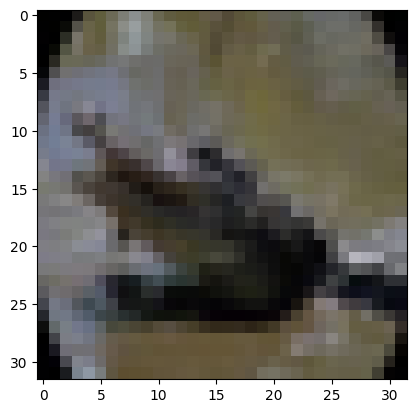

In [ ]:
import matplotlib.pyplot as plt
index_pic = 92
print(list(y_test[index_pic]).index(1))
print(fine_labels[list(y_test[index_pic]).index(1)])
print(x_test[index_pic].shape)
plt.imshow(x_test[index_pic])

In [ ]:
print(0.5/output_scale + output_zero_point)

128.0


In [ ]:
# Specify the path to your .tar file
tar_file_path = 'drive/MyDrive/DL_Project/CFAR100/CIFAR-100-C.tar'

# Open the .tar file
with tarfile.open(tar_file_path, 'r') as tar:
    # Extract all files in the .tar file to the current directory
    tar.extractall()

# **Analysis of the Ignored Samples**

In [ ]:
# Helper function to evaluate a TFLite model on specific images
def inference_analysis(x_test, y_test, tflite_file, model_type, test_index):
  print(len(x_test))
  x_tes = x_test[0:100]
  y_tes = y_test[0:100]
  # print(x_tes)
  test_image_indices = [test_index]
  print(len(test_image_indices))
  predictions = run_tflite_model(tflite_file, test_image_indices)
  print(predictions)
  accuracy = accuracy_score(predictions, [y_tes[test_index]])*100
  f1_score_val = f1_score(predictions, [y_tes[test_index]], average='micro')*100

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(x_tes)))
  print('%s model f1 score is %.4f%% (Number of test samples=%d)' % (
      model_type, f1_score_val, len(x_tes)))
  return accuracy, f1_score_val, predictions

In [ ]:
misclassified_samples = 0
ignored_samples = [1,2,5,8,10,11,35,43,48,49,50,55,63,70,79,86,87,92,96]
misclassified_samples_indexes = []
for ignored_sample_index in ignored_samples:
    print("For ignored sample: ", str(ignored_sample_index))
    acc, f1,_ = inference_analysis(x_test, y_test, tflite_model_quant_file, "Quantized", ignored_sample_index)
    if(f1==0):
        misclassified_samples += 1
        misclassified_samples_indexes.append(ignored_sample_index)
    print()

print("Misclassified %age = ", str(misclassified_samples/len(ignored_samples)))
print("Misclassified samples indexes = ", misclassified_samples_indexes)


For ignored sample:  1
10000
1
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
Quantized model accuracy is 0.0000% (Number of test samples=100)
Quantized model f1 score is 0.0000% (Number of test samples=100)

For ignored sample:  2
10000
1
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
Quantized model accuracy is 0.0000% (Number of test samples=100)
Quantized model f1 score is 0.0000% (Number of test samples=100)

For ignored sample:  5
10000
1
[[0. 0. 0. 0. 0. 0. 1

In [ ]:
fine_labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

In [ ]:
fine_labels[51]

'mushroom'

15 15


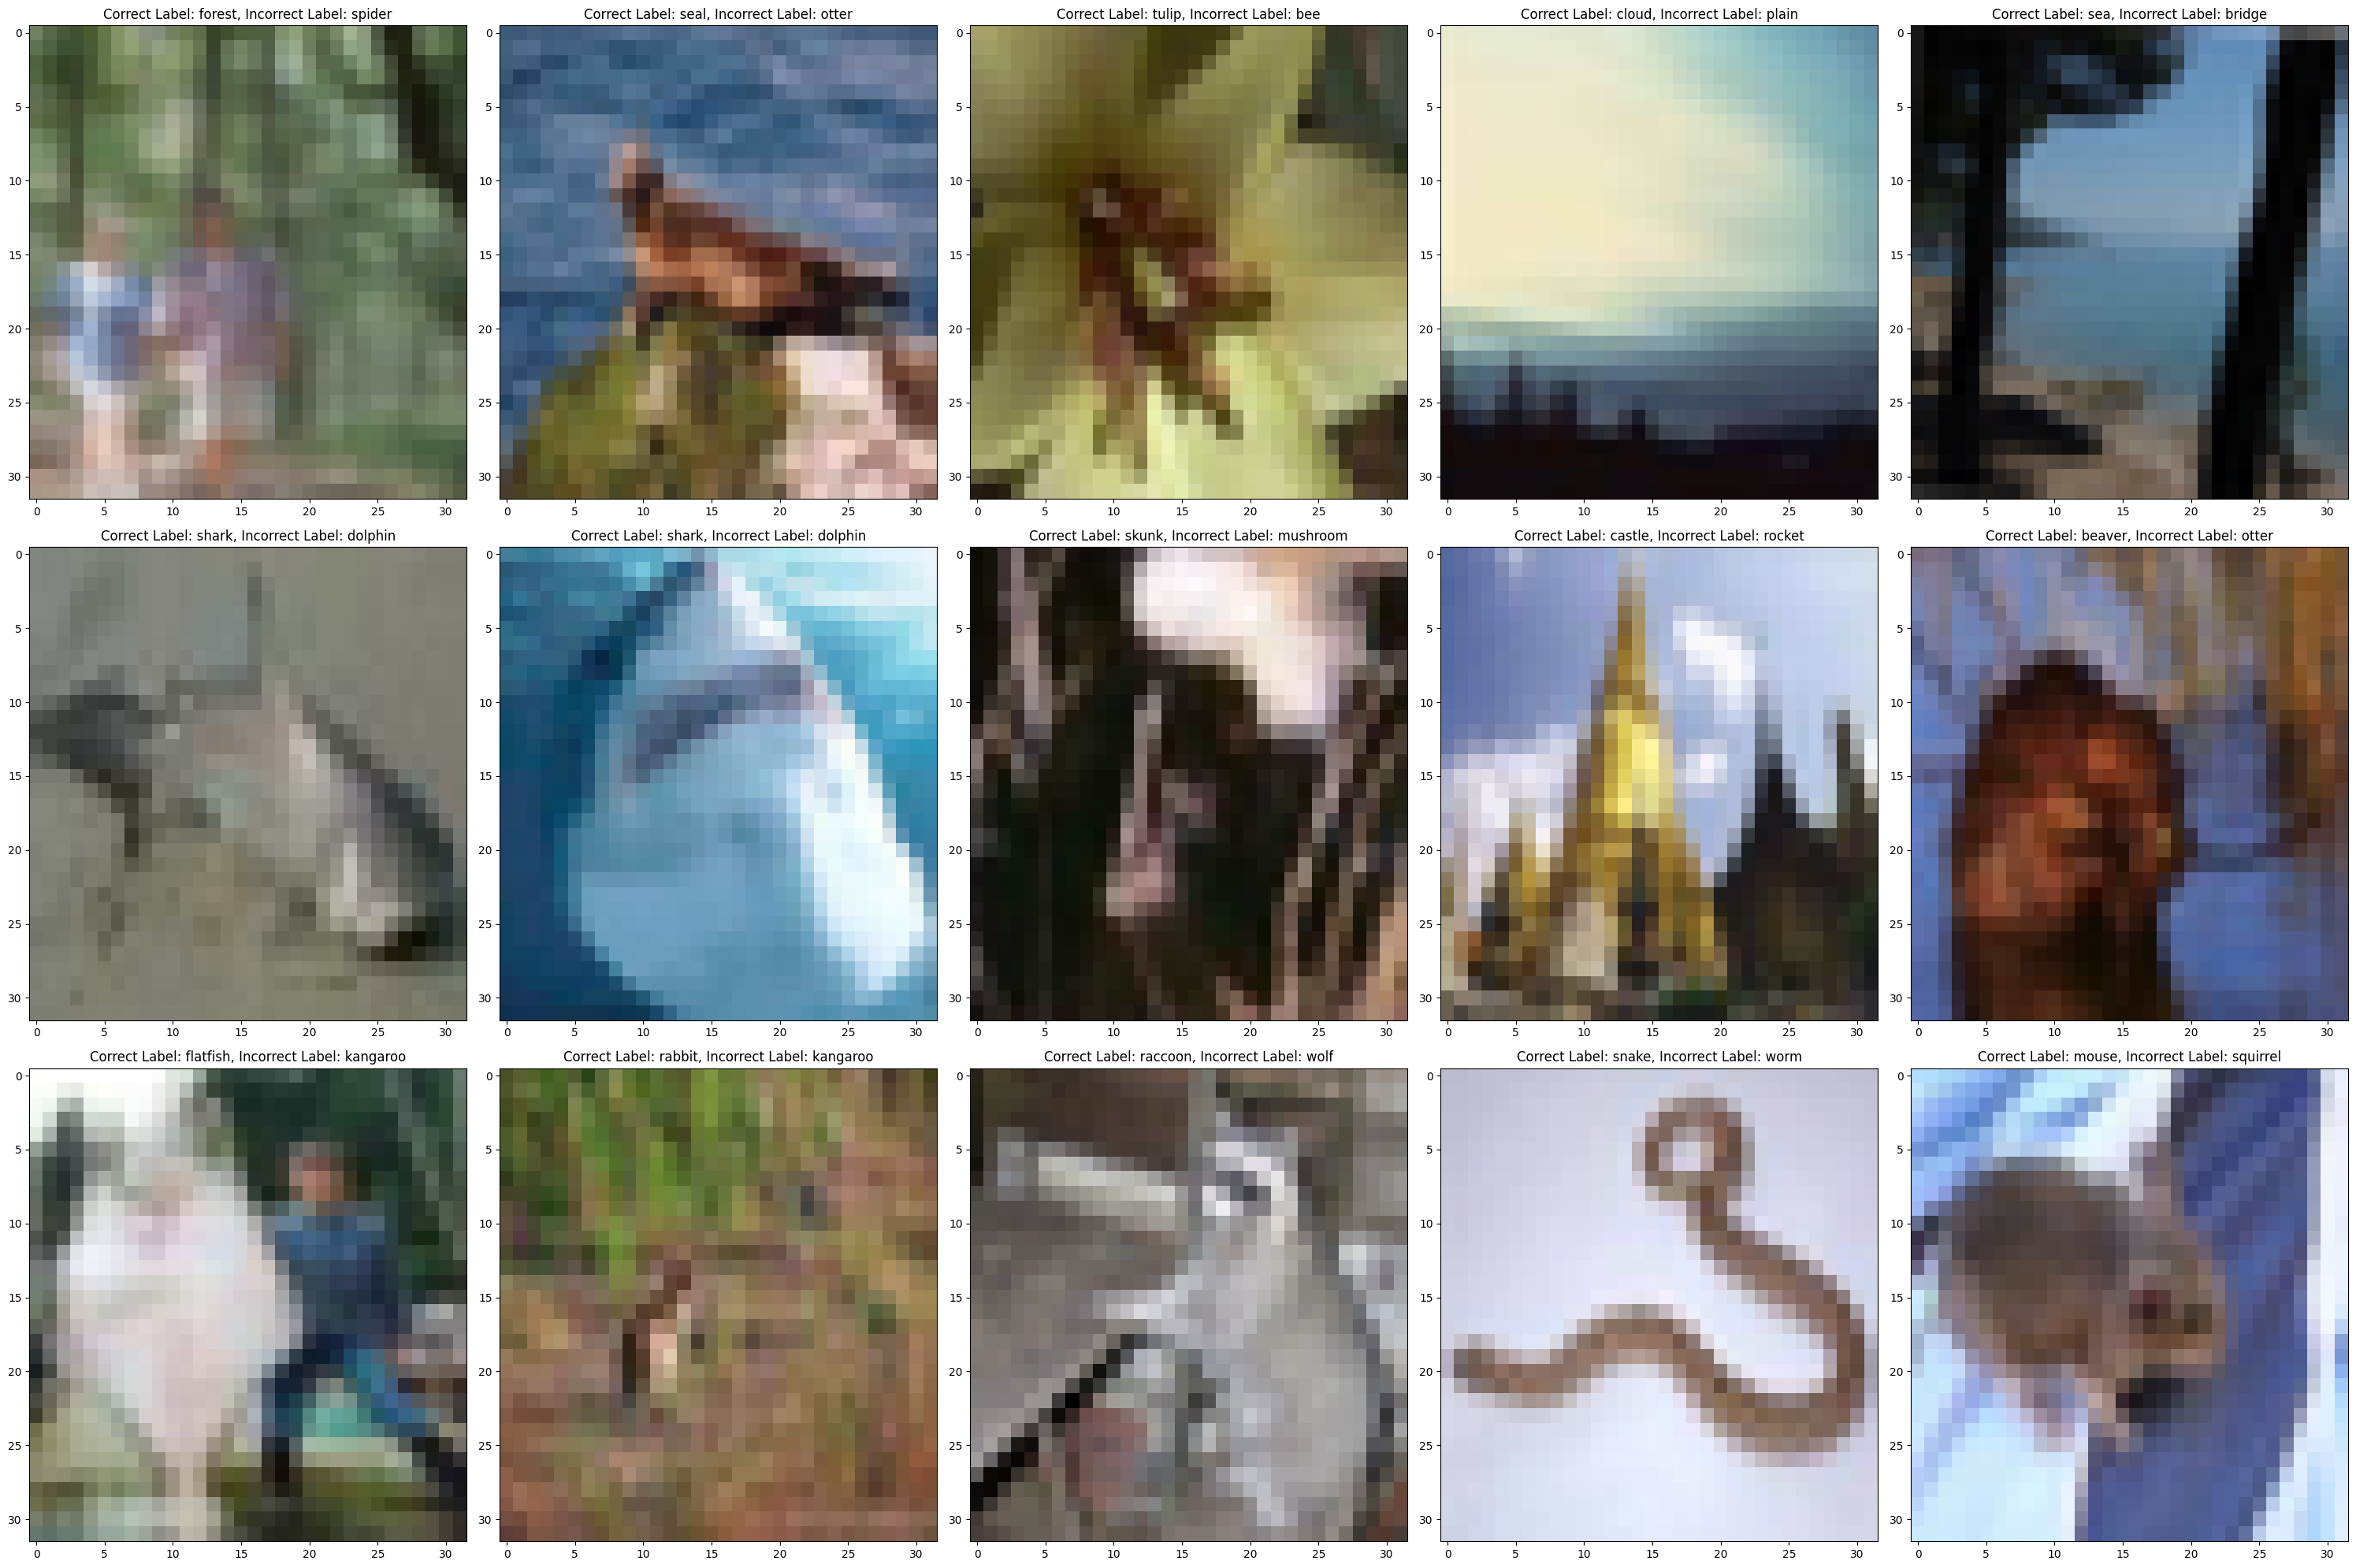

In [ ]:
incorrect_labels = [79,55,6,60,12,30,30,51,69,55,38,38,97,99,80]
misclassified_samples_indexes = [1, 2, 5, 8, 10, 35, 43, 48, 49, 50, 55, 63, 70, 86, 96]
print(len(incorrect_labels), len(misclassified_samples_indexes))
# Number of images
num_images = len(misclassified_samples_indexes)

# Set up the subplot grid dynamically based on the number of images
num_cols = 5
num_rows = -(-num_images // num_cols)  # Equivalent to math.ceil(num_images / num_cols)

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 20))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

# Create subplots
for i in range(num_images):
    axes[i].imshow(x_test[misclassified_samples_indexes[i]], aspect='auto')  # Use cmap if the images are grayscale
    axes[i].set_title('Correct Label: ' + str(fine_labels[list(y_test[misclassified_samples_indexes[i]]).index(1)])+ ", Incorrect Label: " + str(fine_labels[incorrect_labels[i]]))

# Hide empty subplots if there are more subplots than images
for j in range(num_images, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

# **Analysis Part of the Ignored Samples for CFAR100-C(Severity - 1)**


In [ ]:
noise_types = ["defocus_blur.npy", "snow.npy", "elastic_transform.npy", "gaussian_noise.npy"]
ignored_samples_arr = [[1,3,4,6,9,10,11,15,17], [1,2,4,5,6,7,8,9,10,11,15,16], [0,2,3,6,8,9,10,11,17], [0,2,4,5,6,7,8,9,10,11,13,15,16,17,18,19]]
misclassified_samples_indexes_cfar100c_sev1 = []
misclassified_samples_labels_cfar100c_sev1 = []

for i in range(len(noise_types)):
    misclassified_samples = 0
    noise = noise_types[i]
    print("For noise: ", noise)
    img_set = np.load('CIFAR-100-C/'+noise)
    img_set = img_set[:20]
    index_arr = []
    incorrect_labels_arr = []
    ignored_samples = ignored_samples_arr[i]

    for ignored_sample_index in ignored_samples:
        print("For ignored sample: ", str(ignored_sample_index))
        acc, f1, pred = inference_analysis(img_set, y_test, tflite_model_quant_file, "Quantized", ignored_sample_index)
        if(f1==0):
            misclassified_samples += 1
            index_1 = list(pred[0]).index(1)
            incorrect_labels_arr.append(index_1)
            index_arr.append(ignored_sample_index)
        print()

    misclassified_samples_labels_cfar100c_sev1.append(incorrect_labels_arr)
    misclassified_samples_indexes_cfar100c_sev1.append(index_arr)

    print("Misclassified %age = ", str(misclassified_samples/len(ignored_samples)))
    print("Misclassified samples indexes = ", index_arr)
    print("Misclassified samples labels = ", incorrect_labels_arr)
    print()

For noise:  defocus_blur.npy
For ignored sample:  1
20
1
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
Quantized model accuracy is 0.0000% (Number of test samples=20)
Quantized model f1 score is 0.0000% (Number of test samples=20)

For ignored sample:  3
20
1
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
Quantized model accuracy is 100.0000% (Number of test samples=20)
Quantized model f1 score is 100.0000% (Number of test samples=20)

For ignored sample:  4
20
1
[

In [ ]:
misclassified_samples_labels_cfar100c_sev1 = [[80, 29, 53, 51], [80, 95, 23, 0, 29, 74, 53, 51],[68, 30, 29, 60, 15, 74], [68, 30, 0, 29, 74, 71]]
misclassified_samples_indexes_cfar100c_sev1 = [[1, 6, 9, 11],[1, 2, 4, 5, 6, 7, 9, 11],[0, 2, 6, 8, 10, 11], [0, 2, 5, 6, 7, 8]]

[[80, 29, 53, 51], [80, 95, 23, 0, 29, 74, 53, 51], [68, 30, 29, 60, 15, 74], [68, 30, 0, 29, 74, 71]]
[[1, 6, 9, 11], [1, 2, 4, 5, 6, 7, 9, 11], [0, 2, 6, 8, 10, 11], [0, 2, 5, 6, 7, 8]]
For defocus blur: 


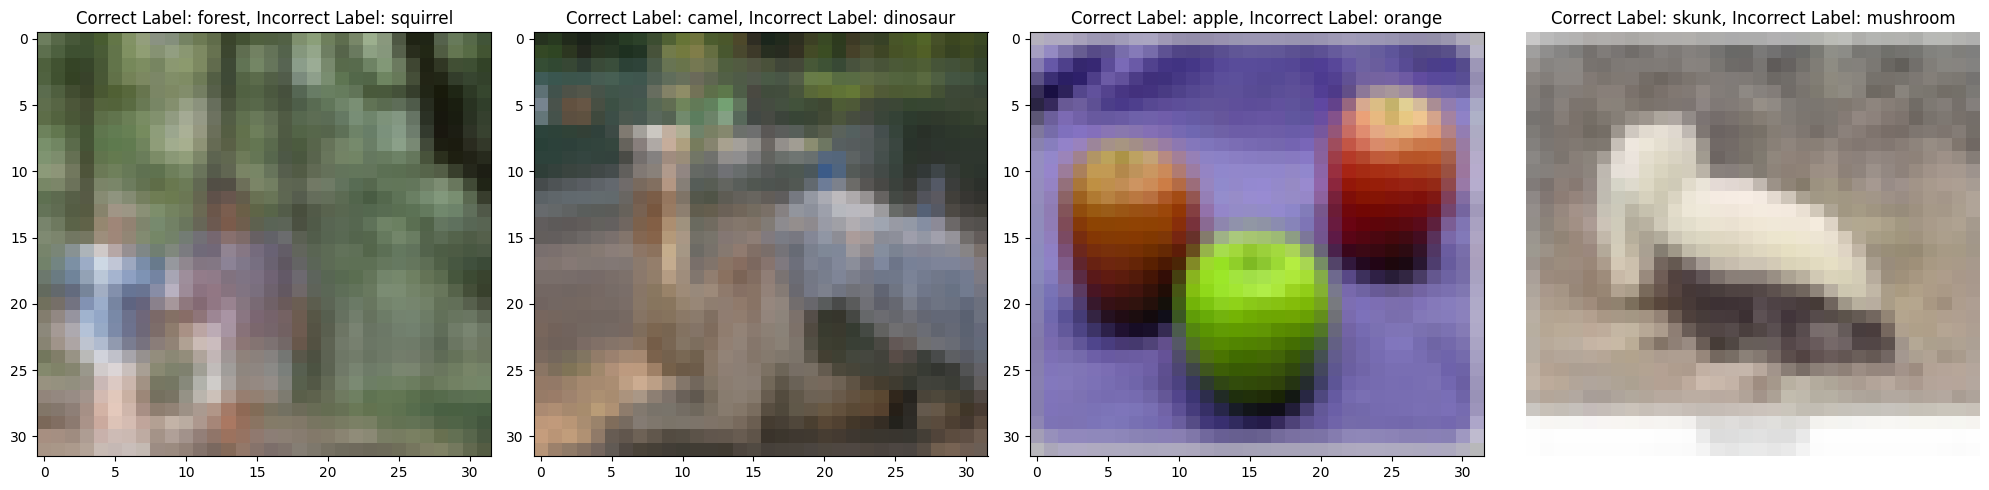

In [ ]:
print(misclassified_samples_labels_cfar100c_sev1)
print(misclassified_samples_indexes_cfar100c_sev1)
print("For defocus blur: ")
# Number of images
num_images = len(misclassified_samples_indexes_cfar100c_sev1[0])

# Set up the subplot grid dynamically based on the number of images
num_cols = 4
num_rows = -(-num_images // num_cols)  # Equivalent to math.ceil(num_images / num_cols)

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

# Create subplots
img_set_defocus_blur = np.load("CIFAR-100-C/defocus_blur.npy")
for i in range(num_images):
    axes[i].imshow(img_set_defocus_blur[misclassified_samples_indexes_cfar100c_sev1[0][i]], aspect='auto')  # Use cmap if the images are grayscale
    axes[i].set_title('Correct Label: ' + str(fine_labels[list(y_test[misclassified_samples_indexes_cfar100c_sev1[0][i]]).index(1)])+ ", Incorrect Label: " + str(fine_labels[misclassified_samples_labels_cfar100c_sev1[0][i]]))

# Hide empty subplots if there are more subplots than images
for j in range(num_images, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout for better display
plt.tight_layout()
plt.axis("off")

# Show the plot
plt.show()

[[80, 29, 53, 51], [80, 95, 23, 0, 29, 74, 53, 51], [68, 30, 29, 60, 15, 74], [68, 30, 0, 29, 74, 71]]
[[1, 6, 9, 11], [1, 2, 4, 5, 6, 7, 9, 11], [0, 2, 6, 8, 10, 11], [0, 2, 5, 6, 7, 8]]
Snow: 


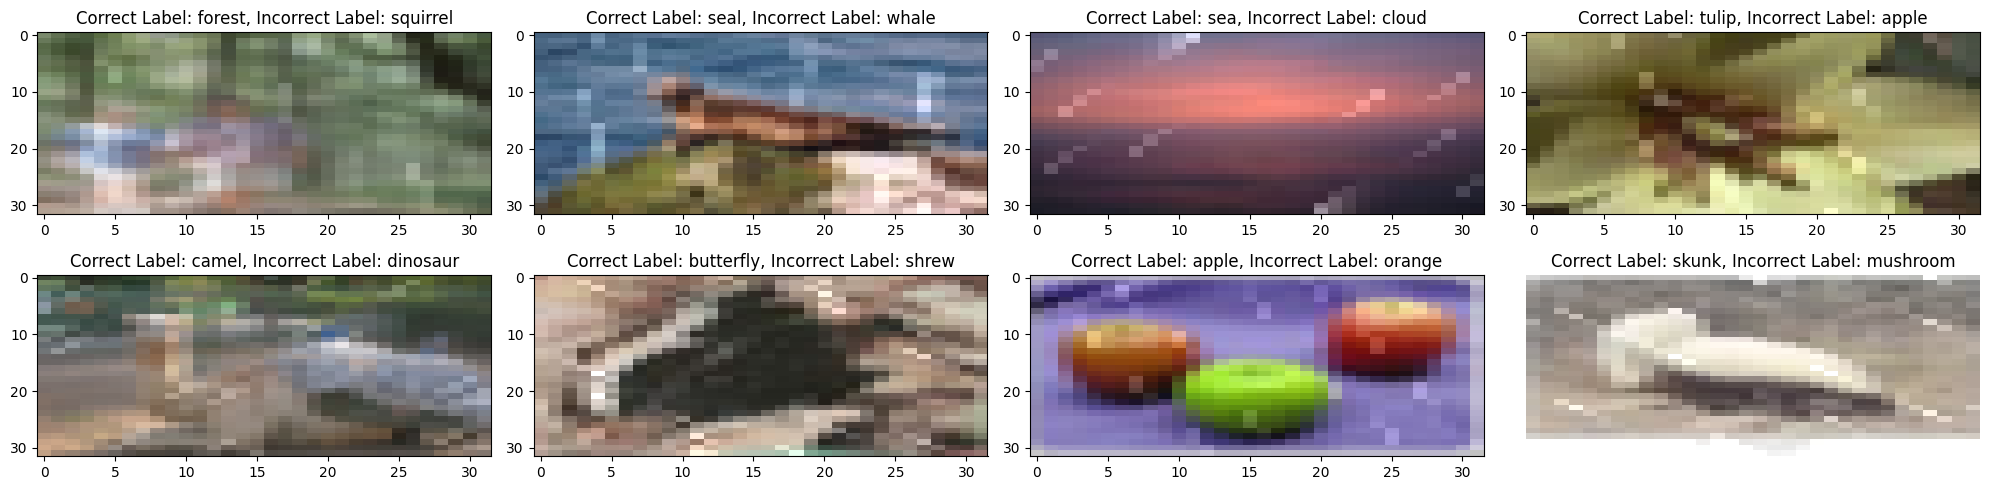

In [ ]:
print(misclassified_samples_labels_cfar100c_sev1)
print(misclassified_samples_indexes_cfar100c_sev1)
print("Snow: ")
# Number of images
num_images = len(misclassified_samples_indexes_cfar100c_sev1[1])

# Set up the subplot grid dynamically based on the number of images
num_cols = 4
num_rows = -(-num_images // num_cols)  # Equivalent to math.ceil(num_images / num_cols)

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

# Create subplots
img_set_snow = np.load("CIFAR-100-C/snow.npy")
for i in range(num_images):
    axes[i].imshow(img_set_snow[misclassified_samples_indexes_cfar100c_sev1[1][i]], aspect='auto')  # Use cmap if the images are grayscale
    axes[i].set_title('Correct Label: ' + str(fine_labels[list(y_test[misclassified_samples_indexes_cfar100c_sev1[1][i]]).index(1)])+ ", Incorrect Label: " + str(fine_labels[misclassified_samples_labels_cfar100c_sev1[1][i]]))

# Hide empty subplots if there are more subplots than images
for j in range(num_images, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout for better display
plt.tight_layout()
plt.axis("off")

# Show the plot
plt.show()

[[80, 29, 53, 51], [80, 95, 23, 0, 29, 74, 53, 51], [68, 30, 29, 60, 15, 74], [68, 30, 0, 29, 74, 71]]
[[1, 6, 9, 11], [1, 2, 4, 5, 6, 7, 9, 11], [0, 2, 6, 8, 10, 11], [0, 2, 5, 6, 7, 8]]
Elastic transform: 


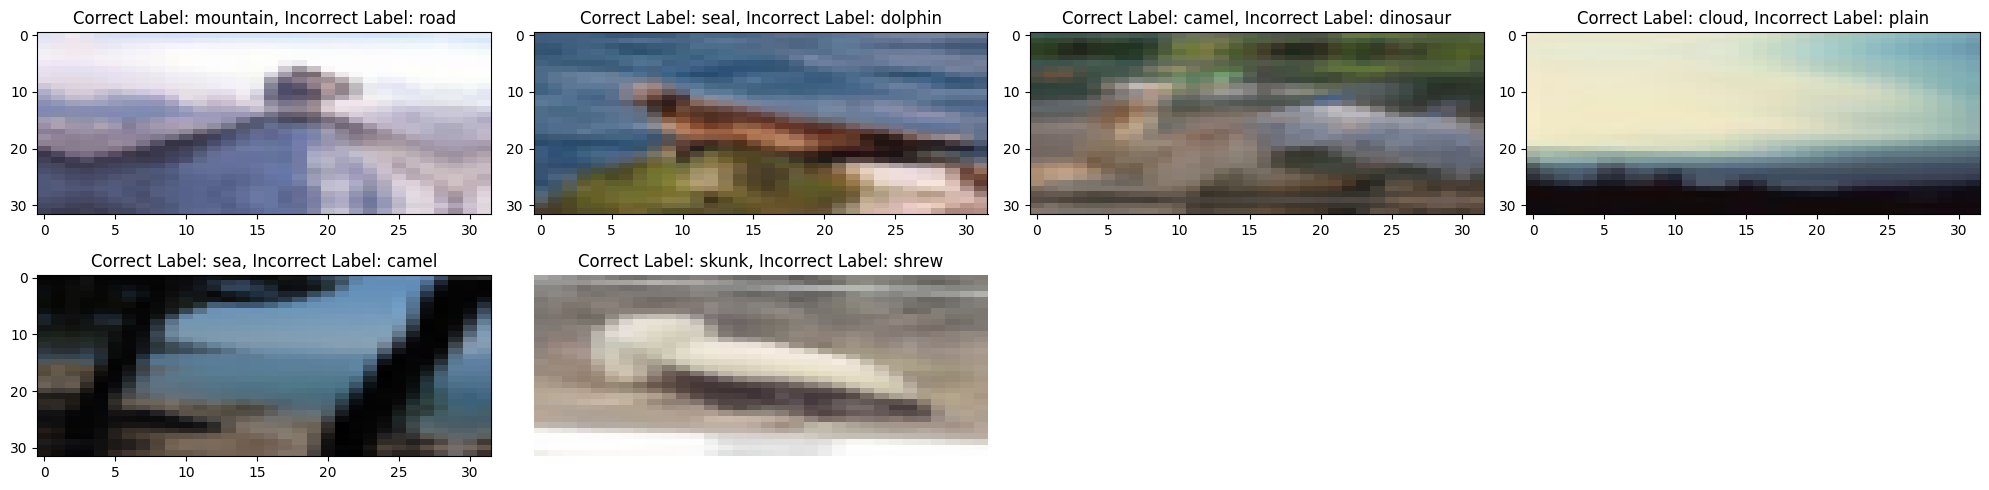

In [ ]:
print(misclassified_samples_labels_cfar100c_sev1)
print(misclassified_samples_indexes_cfar100c_sev1)
print("Elastic transform: ")
# Number of images
num_images = len(misclassified_samples_indexes_cfar100c_sev1[2])

# Set up the subplot grid dynamically based on the number of images
num_cols = 4
num_rows = -(-num_images // num_cols)  # Equivalent to math.ceil(num_images / num_cols)

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

# Create subplots
img_set_snow = np.load("CIFAR-100-C/elastic_transform.npy")
for i in range(num_images):
    axes[i].imshow(img_set_snow[misclassified_samples_indexes_cfar100c_sev1[2][i]], aspect='auto')  # Use cmap if the images are grayscale
    axes[i].set_title('Correct Label: ' + str(fine_labels[list(y_test[misclassified_samples_indexes_cfar100c_sev1[2][i]]).index(1)])+ ", Incorrect Label: " + str(fine_labels[misclassified_samples_labels_cfar100c_sev1[2][i]]))

# Hide empty subplots if there are more subplots than images
for j in range(num_images, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout for better display
plt.tight_layout()
plt.axis("off")

# Show the plot
plt.show()

[[80, 29, 53, 51], [80, 95, 23, 0, 29, 74, 53, 51], [68, 30, 29, 60, 15, 74], [68, 30, 0, 29, 74, 71]]
[[1, 6, 9, 11], [1, 2, 4, 5, 6, 7, 9, 11], [0, 2, 6, 8, 10, 11], [0, 2, 5, 6, 7, 8]]
Gaussian Noise: 


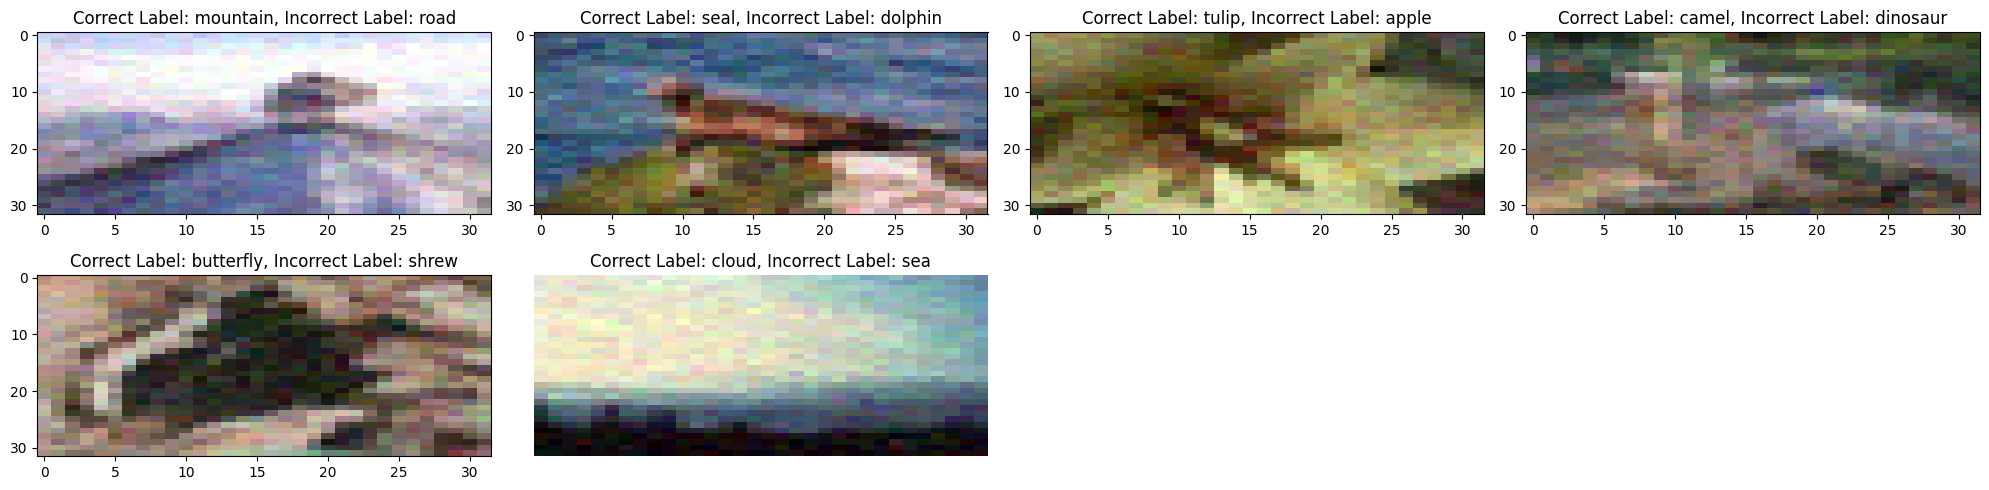

In [ ]:
print(misclassified_samples_labels_cfar100c_sev1)
print(misclassified_samples_indexes_cfar100c_sev1)
print("Gaussian Noise: ")
# Number of images
num_images = len(misclassified_samples_indexes_cfar100c_sev1[3])

# Set up the subplot grid dynamically based on the number of images
num_cols = 4
num_rows = -(-num_images // num_cols)  # Equivalent to math.ceil(num_images / num_cols)

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

# Create subplots
img_set_snow = np.load("CIFAR-100-C/gaussian_noise.npy")
for i in range(num_images):
    axes[i].imshow(img_set_snow[misclassified_samples_indexes_cfar100c_sev1[3][i]], aspect='auto')  # Use cmap if the images are grayscale
    axes[i].set_title('Correct Label: ' + str(fine_labels[list(y_test[misclassified_samples_indexes_cfar100c_sev1[3][i]]).index(1)])+ ", Incorrect Label: " + str(fine_labels[misclassified_samples_labels_cfar100c_sev1[3][i]]))

# Hide empty subplots if there are more subplots than images
for j in range(num_images, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout for better display
plt.tight_layout()
plt.axis("off")

# Show the plot
plt.show()

# **Analysis Part of the Ignored Samples for CFAR100-C(Severity - 5)**


In [ ]:
noise_types = ["defocus_blur.npy", "snow.npy", "elastic_transform.npy", "gaussian_noise.npy"]
ignored_samples_arr = [[0,1,2,3,4,6,9,10,12,15,17], [3,5,8,9,10,11,13,15,18], [0,1,2,3,6,10,12,14,15,16,19], [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]]
misclassified_samples_indexes_cfar100c_sev5 = []
misclassified_samples_labels_cfar100c_sev5 = []

for i in range(len(noise_types)):
    misclassified_samples = 0
    noise = noise_types[i]
    print("For noise: ", noise)
    img_set = np.load('CIFAR-100-C/'+noise)
    img_set = img_set[40000:]
    img_set = img_set[:20]
    index_arr = []
    incorrect_labels_arr = []
    ignored_samples = ignored_samples_arr[i]

    for ignored_sample_index in ignored_samples:
        print("For ignored sample: ", str(ignored_sample_index))
        acc, f1, pred = inference_analysis(img_set, y_test, tflite_model_quant_file, "Quantized", ignored_sample_index)
        if(f1==0):
            misclassified_samples += 1
            index_1 = list(pred[0]).index(1)
            incorrect_labels_arr.append(index_1)
            index_arr.append(ignored_sample_index)
        print()

    misclassified_samples_labels_cfar100c_sev5.append(incorrect_labels_arr)
    misclassified_samples_indexes_cfar100c_sev5.append(index_arr)

    print("Misclassified %age = ", str(misclassified_samples/len(ignored_samples)))
    print("Misclassified samples indexes = ", index_arr)
    print("Misclassified samples labels = ", incorrect_labels_arr)
    print()


For noise:  defocus_blur.npy
For ignored sample:  0
20
1
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
Quantized model accuracy is 0.0000% (Number of test samples=20)
Quantized model f1 score is 0.0000% (Number of test samples=20)

For ignored sample:  1
20
1
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
Quantized model accuracy is 100.0000% (Number of test samples=20)
Quantized model f1 score is 100.0000% (Number of test samples=20)

For ignored sample:  2
20
1
[

In [ ]:
misclassified_samples_indexes_cfar100c_sev5 = [[1, 2, 6, 9, 10], [5, 9, 10, 11], [0, 1, 2, 6, 10, 12], [0, 1, 2, 5, 6, 7, 8, 9, 11]]
misclassified_samples_labels_cfar100c_sev5 = [[80, 55, 29, 53, 84],[6, 53, 12, 51], [68, 80, 30, 29, 56, 90], [68, 88, 30, 6, 29, 74, 71, 57, 30]]

For defocus blur: 


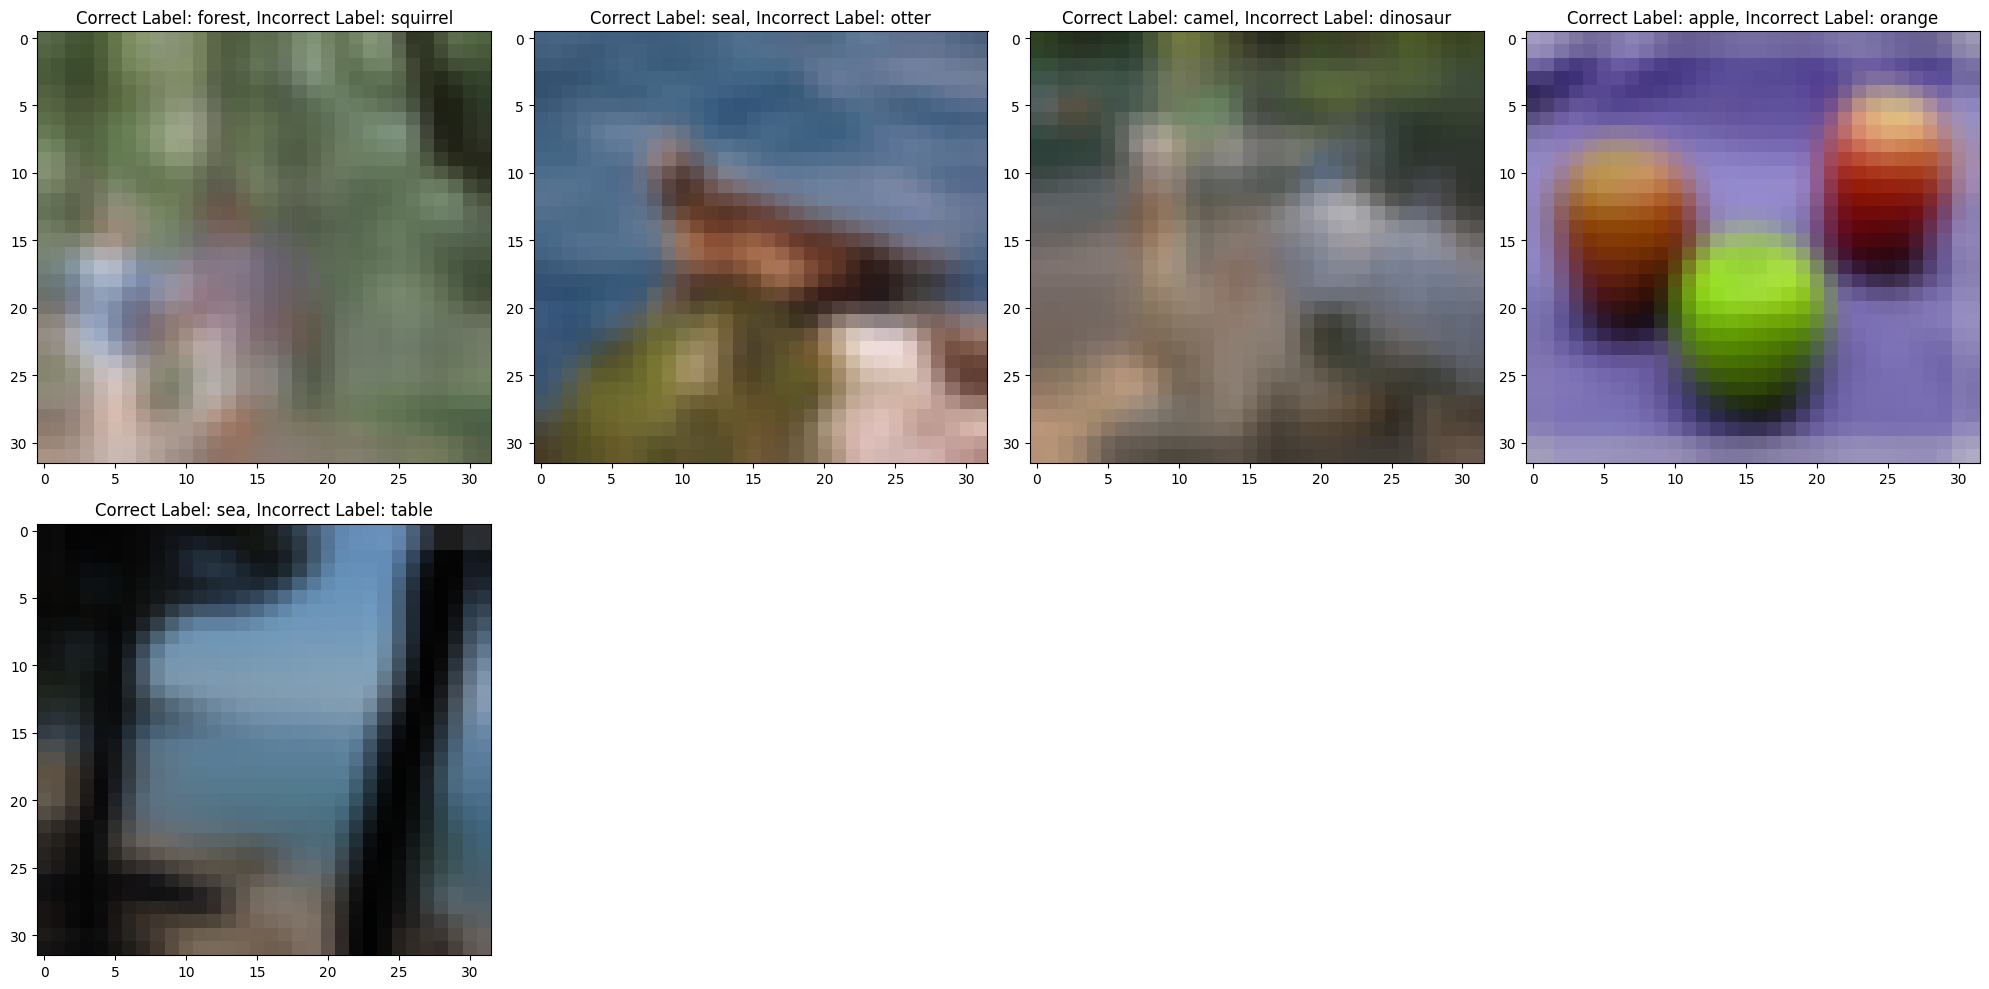

In [ ]:
print("For defocus blur: ")
# Number of images
num_images = len(misclassified_samples_indexes_cfar100c_sev5[0])

# Set up the subplot grid dynamically based on the number of images
num_cols = 4
num_rows = -(-num_images // num_cols)  # Equivalent to math.ceil(num_images / num_cols)

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

# Create subplots
img_set_defocus_blur = np.load("CIFAR-100-C/defocus_blur.npy")
img_set_defocus_blur = img_set_defocus_blur[40000:]
for i in range(num_images):
    axes[i].imshow(img_set_defocus_blur[misclassified_samples_indexes_cfar100c_sev5[0][i]], aspect='auto')  # Use cmap if the images are grayscale
    axes[i].set_title('Correct Label: ' + str(fine_labels[list(y_test[misclassified_samples_indexes_cfar100c_sev5[0][i]]).index(1)])+ ", Incorrect Label: " + str(fine_labels[misclassified_samples_labels_cfar100c_sev5[0][i]]))

# Hide empty subplots if there are more subplots than images
for j in range(num_images, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

For snow: 


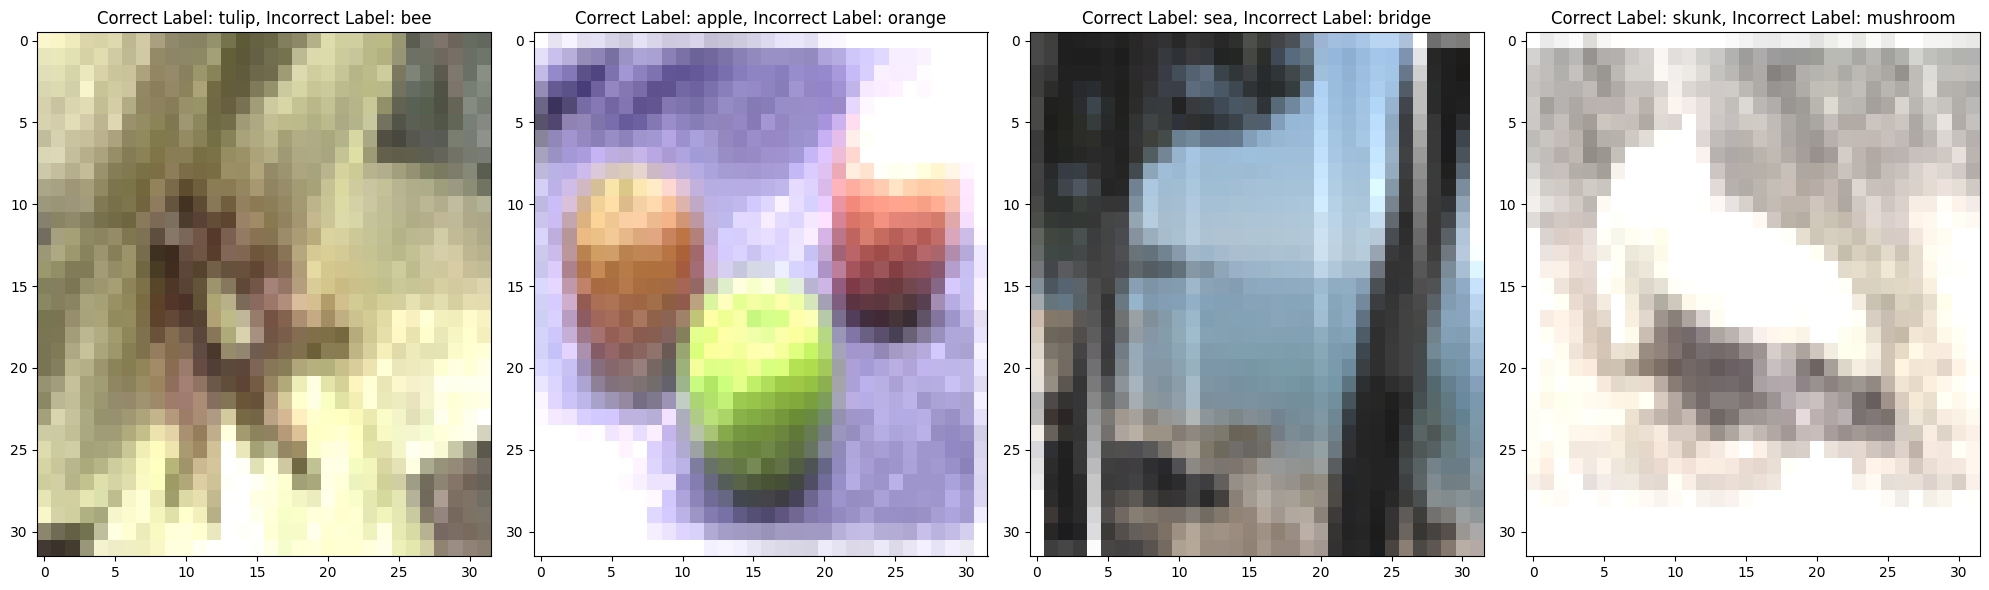

In [ ]:
print("For snow: ")
# Number of images
num_images = len(misclassified_samples_indexes_cfar100c_sev5[1])

# Set up the subplot grid dynamically based on the number of images
num_cols = 4
num_rows = -(-num_images // num_cols)  # Equivalent to math.ceil(num_images / num_cols)

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 6))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

# Create subplots
img_set_defocus_blur = np.load("CIFAR-100-C/snow.npy")
img_set_defocus_blur = img_set_defocus_blur[40000:]
for i in range(num_images):
    axes[i].imshow(img_set_defocus_blur[misclassified_samples_indexes_cfar100c_sev5[1][i]], aspect='auto')  # Use cmap if the images are grayscale
    axes[i].set_title('Correct Label: ' + str(fine_labels[list(y_test[misclassified_samples_indexes_cfar100c_sev5[1][i]]).index(1)])+ ", Incorrect Label: " + str(fine_labels[misclassified_samples_labels_cfar100c_sev5[1][i]]))

# Hide empty subplots if there are more subplots than images
for j in range(num_images, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

For elastic transform: 
6
8


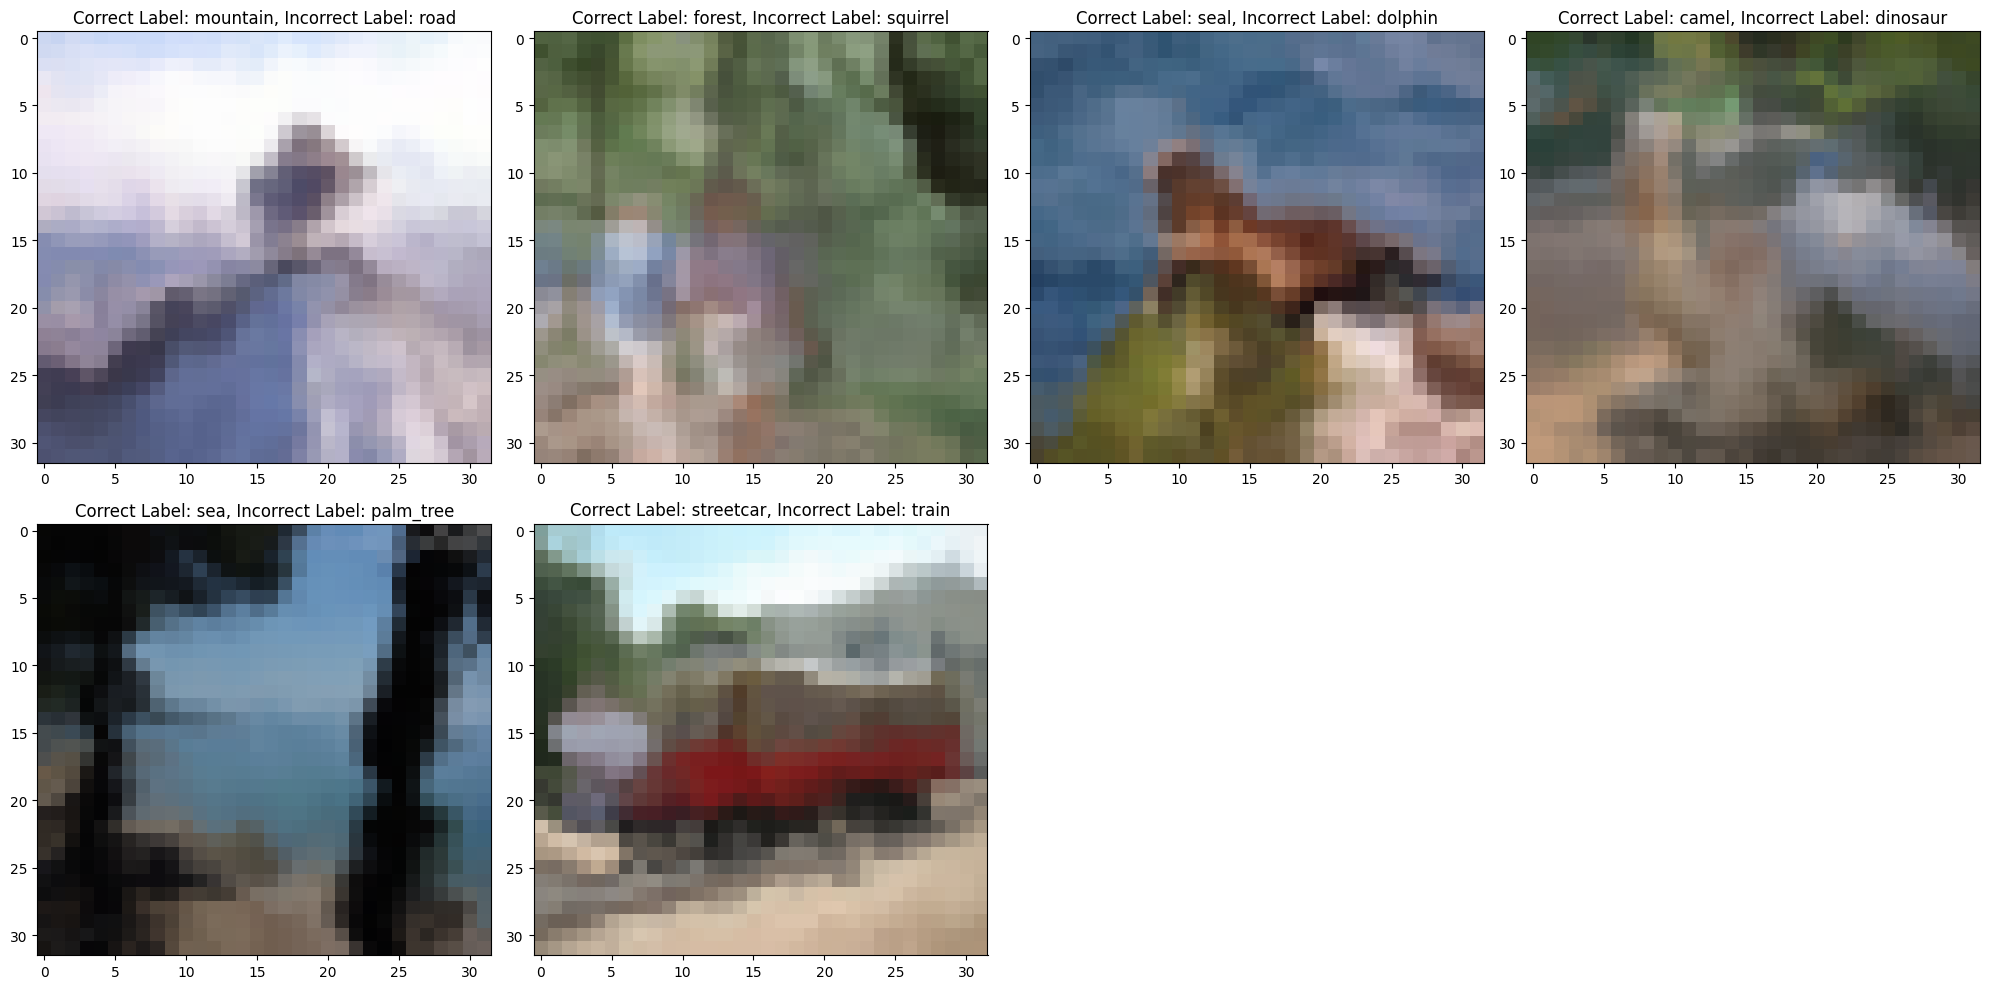

In [ ]:
print("For elastic transform: ")
# Number of images
num_images = len(misclassified_samples_indexes_cfar100c_sev5[2])
print(num_images)

# Set up the subplot grid dynamically based on the number of images
num_cols = 4
num_rows = -(-num_images // num_cols)  # Equivalent to math.ceil(num_images / num_cols)

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()
print(len(axes))
# Create subplots
img_set_defocus_blur = np.load("CIFAR-100-C/elastic_transform.npy")
img_set_defocus_blur = img_set_defocus_blur[40000:]
for i in range(num_images):
    axes[i].imshow(img_set_defocus_blur[misclassified_samples_indexes_cfar100c_sev5[2][i]], aspect='auto')  # Use cmap if the images are grayscale
    axes[i].set_title('Correct Label: ' + str(fine_labels[list(y_test[misclassified_samples_indexes_cfar100c_sev5[2][i]]).index(1)])+ ", Incorrect Label: " + str(fine_labels[misclassified_samples_labels_cfar100c_sev5[2][i]]))

# Hide empty subplots if there are more subplots than images
for j in range(num_images, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

For gaussian noise: 


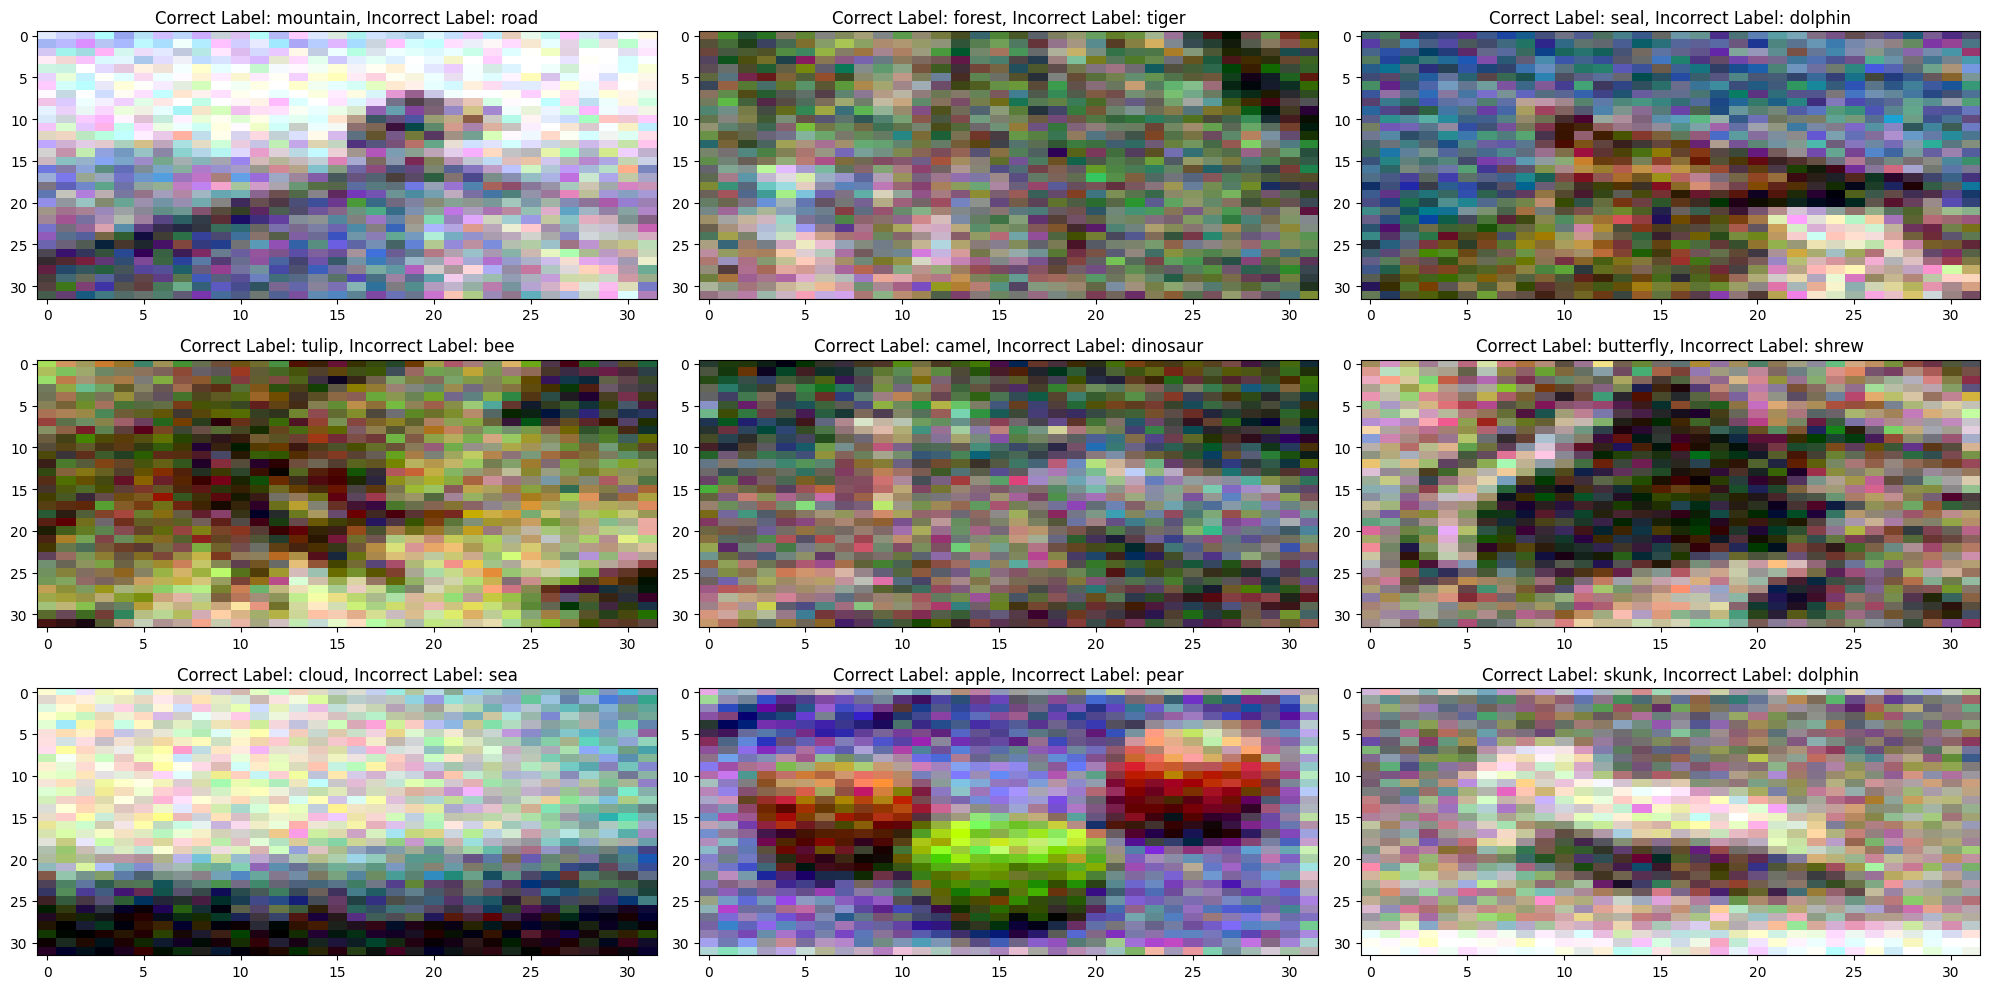

In [ ]:
print("For gaussian noise: ")
# Number of images
num_images = len(misclassified_samples_indexes_cfar100c_sev5[3])

# Set up the subplot grid dynamically based on the number of images
num_cols = 3
num_rows = -(-num_images // num_cols)  # Equivalent to math.ceil(num_images / num_cols)

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,10))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

# Create subplots
img_set_defocus_blur = np.load("CIFAR-100-C/gaussian_noise.npy")
img_set_defocus_blur = img_set_defocus_blur[40000:]
for i in range(num_images):
    axes[i].imshow(img_set_defocus_blur[misclassified_samples_indexes_cfar100c_sev5[3][i]], aspect='auto')  # Use cmap if the images are grayscale
    axes[i].set_title('Correct Label: ' + str(fine_labels[list(y_test[misclassified_samples_indexes_cfar100c_sev5[3][i]]).index(1)])+ ", Incorrect Label: " + str(fine_labels[misclassified_samples_labels_cfar100c_sev5[3][i]]))

# Hide empty subplots if there are more subplots than images
for j in range(num_images, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()